In [8]:

import torch
import torch.nn as nn
from torch.autograd import grad
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [9]:
class LinearNN(nn.Module):
    def __init__(
            self,
            num_inputs: int=1,
            num_layers: int=5,
            num_neurons: int=11,
            act: nn.Module = nn.Tanh()
    ) -> None:
        super().__init__()
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # Input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # Hidden layers
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # Output layers
        layers.append(nn.Linear(num_neurons, 1))

        # Building the network as sequential
        self.network = nn.Sequential(*layers)

    # Setting up the output
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()

# Create an instance of the model
model = LinearNN()

In [10]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Move the model to the GPU
    device = torch.device("cuda")
    model.to(device)
    # Print message if the model will be trained on the GPU
    print("The model will be trained on the GPU")
else:
    # Print message if the GPU is not available
    print("GPU is not available. The model will be trained on the CPU")

The model will be trained on the GPU


In [11]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the parameters (move to GPU)
num_samples = 50000

# Define the function for the analytical solution
def x_analytical(t_train):
    x0 = 10  # Initial position
    v = 2  # Constant velocity
    return torch.clamp(x0 + v * t_train, min=0).to(device)  # Rectified linear movement (URM)

# Define your dataset
t = torch.rand(100, 1).to(device)  # Move to GPU
x_analytic = x_analytical(t)

# Split the dataset into training and testing subsets
t_train, t_test, x_train, x_test = train_test_split(t.cpu(), x_analytic.cpu(), test_size=0.2, random_state=42)  # Move to CPU for splitting

# Move training and testing data to GPU
t_train, x_train = t_train.to(device), x_train.to(device)
t_test, x_test = t_test.to(device), x_test.to(device)

# Create TensorDatasets for training and testing
train_dataset = TensorDataset(t_train, x_train)
test_dataset = TensorDataset(t_test, x_test)

# Define batch size for training and testing data loaders
batch_size = 64

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print out some data points for illustration
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))


Train dataset size: 80
Test dataset size: 20


In [12]:
import torch
from torch.autograd import grad

# Define the parameters (move to GPU)
v = torch.tensor(2.0, device=device)  # Constant velocity on the same device as x_pred

# Loss function
def loss_fn(output, t_train, x_analytic):

    # Forward pass: compute predicted outputs by passing inputs to the model
    x_pred = model(t_train)

    x_pred = output 
    t_train = t_train

    # Compute the time derivative of the predicted outputs
    xt_train_dot = torch.autograd.grad(x_pred, t_train, grad_outputs=torch.ones_like(x_pred), create_graph=True)[0]

    # Compute the loss
    loss = torch.mean(torch.square(xt_train_dot - v)) + torch.mean(torch.square(x_pred - x_analytic))

    return loss


In [13]:
def accuracy(predictions, targets):
    # Compute Mean Absolute Error (MAE)
    absolute_errors = torch.abs(predictions - targets)
    mae = torch.mean(absolute_errors)
    return mae

In [14]:
# Move the model to the GPU
model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs
epochs = 25000

# Initialize lists to store loss, MSE, and MAE
losses = []
mses = []
maes = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Initialize metrics
    total_loss = 0
    total_mse = 0
    total_mae = 0
    total_samples = 0

    # Forward pass: compute predicted outputs by passing inputs to the model
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs.requires_grad_(True)  # Ensure gradients are computed for inputs
        outputs = model(inputs)

        # Calculate loss using your loss function
        loss = loss_fn(outputs, inputs, targets)  # Pass outputs, inputs, and targets to loss function

        # Update total loss
        total_loss += loss.item() * len(inputs)

        # Update total MSE
        mse = ((outputs - targets) ** 2).sum().item()
        total_mse += mse

        # Update total MAE
        mae = torch.abs(outputs - targets).sum().item()
        total_mae += mae

        # Update total samples
        total_samples += len(inputs)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward(retain_graph=True)

        # Update model parameters
        optimizer.step()

    # Calculate average loss, MSE, and MAE
    avg_loss = total_loss / total_samples
    avg_mse = total_mse / total_samples
    avg_mae = total_mae / total_samples

    # Append to the lists
    losses.append(avg_loss)
    mses.append(avg_mse)
    maes.append(avg_mae)

    print(f"Epoch {epoch} with loss {avg_loss}, MSE {avg_mse}, MAE {avg_mae}")

Epoch 0 with loss 126.65773010253906, MSE 6660.65703125, MAE 601.2169921875
Epoch 1 with loss 126.08200225830078, MSE 6655.812890625, MAE 600.9638549804688
Epoch 2 with loss 125.50841979980468, MSE 6636.511083984375, MAE 600.0865081787109
Epoch 3 with loss 124.92322692871093, MSE 6599.252197265625, MAE 598.3570953369141
Epoch 4 with loss 124.32574005126953, MSE 6544.186303710938, MAE 595.9073181152344
Epoch 5 with loss 123.71480712890624, MSE 6501.826708984375, MAE 593.9328491210938
Epoch 6 with loss 123.08820190429688, MSE 6466.1990234375, MAE 592.301889038086
Epoch 7 with loss 122.44523010253906, MSE 6468.622216796875, MAE 592.3956024169922
Epoch 8 with loss 121.78193511962891, MSE 6430.371630859375, MAE 590.6323028564453
Epoch 9 with loss 121.0949493408203, MSE 6302.940356445312, MAE 584.7792663574219
Epoch 10 with loss 120.39320373535156, MSE 6353.443383789063, MAE 587.0990966796875
Epoch 11 with loss 119.66435394287109, MSE 6309.967041015625, MAE 585.1414428710938
Epoch 12 with lo

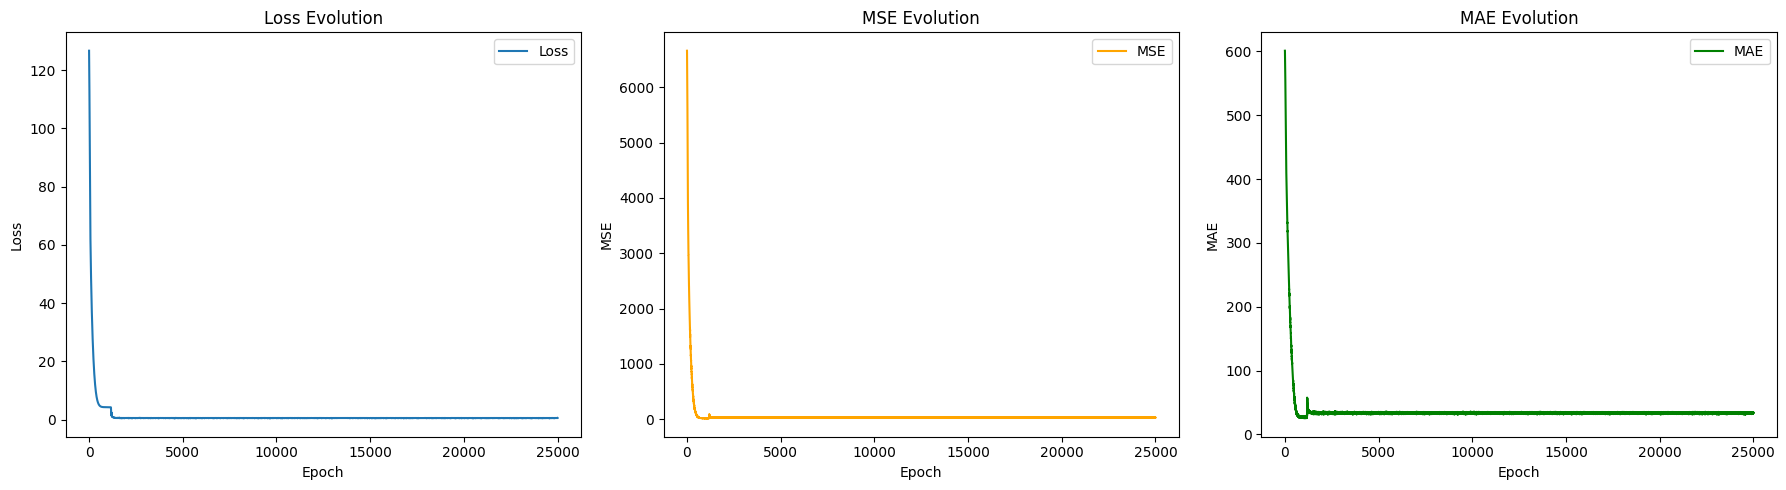

In [19]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(range(epochs), losses, label='Loss')
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot MSE
plt.subplot(1, 3, 2)
plt.plot(range(epochs), mses, label='MSE', color='orange')
plt.title('MSE Evolution')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 3, 3)
plt.plot(range(epochs), maes, label='MAE', color='green')
plt.title('MAE Evolution')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


/tmp/ipykernel_21137/393245627.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t, device=device)


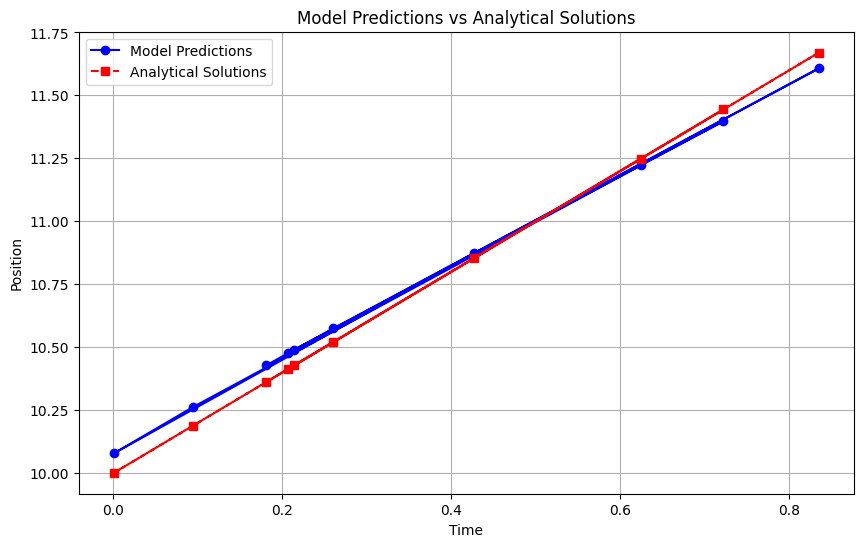

In [30]:
# Define a set of different times
times = torch.rand(10, 1)  # Move to GPU

# Initialize lists to store model predictions and analytical solutions for each time
model_predictions = []
analytical_solutions = []

# Calculate model predictions and analytical solutions for each time
for t in times:
    # Move t to the device
    t_tensor = torch.tensor(t, device=device)
    
    # Get model prediction
    with torch.no_grad():
        x_pred = model(t_tensor).cpu().item()
    
    # Calculate analytical solution
    x_analytic = x_analytical(t_tensor).cpu().item()
    
    # Append to lists
    model_predictions.append(x_pred)
    analytical_solutions.append(x_analytic)

# Plot model predictions and analytical solutions against time
plt.figure(figsize=(10, 6))
plt.plot(times, model_predictions, marker='o', linestyle='-', color='blue', label='Model Predictions')
plt.plot(times, analytical_solutions, marker='s', linestyle='--', color='red', label='Analytical Solutions')
plt.title('Model Predictions vs Analytical Solutions')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.show()
